# Intestinal organoid differentiation - Parameter analysis

Consistency analysis of inferred rates. Compares rates of a reference cell with its neighbors through cosine similarity.

In [1]:
%load_ext autoreload
%autoreload 2

## Library imports

In [2]:
import itertools
import os
import sys

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv

from cr2 import get_consistency

sys.path.extend(["../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [3]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3

In [4]:
scv.settings.set_figure_params("scvelo")

In [5]:
SAVE_FIGURES = True

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Data loading

In [6]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "preprocessed.h5ad")

adata.layers["alpha"] = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "alpha.csv", index_col=0).values
adata.layers["gamma"] = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "gamma.csv", index_col=0).values
adata.layers["r0"] = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "r0.csv", index_col=0).values

adata

AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'labeled', 'total', 'unlabeled', 'alpha', 'gamma', 'r0'
    obsp: 'connectivities', 'distances'

## Data preprocessing

In [7]:
adata.layers["alpha_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["alpha"])
adata.layers["gamma_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["gamma"])
adata.layers["r0_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["r0"])

## Parameter analysis

In [8]:
consistency = {}

consistency["alpha"] = get_consistency(adata.layers["alpha"].copy(), adata.obsp["connectivities"])
consistency["alpha (smoothed)"] = get_consistency(adata.layers["alpha_smoothed"].copy(), adata.obsp["connectivities"])

consistency["gamma"] = get_consistency(adata.layers["gamma"].copy(), adata.obsp["connectivities"])
consistency["gamma (smoothed)"] = get_consistency(adata.layers["gamma_smoothed"].copy(), adata.obsp["connectivities"])

consistency["r0"] = get_consistency(adata.layers["r0"].copy(), adata.obsp["connectivities"])
consistency["r0 (smoothed)"] = get_consistency(adata.layers["r0_smoothed"].copy(), adata.obsp["connectivities"])

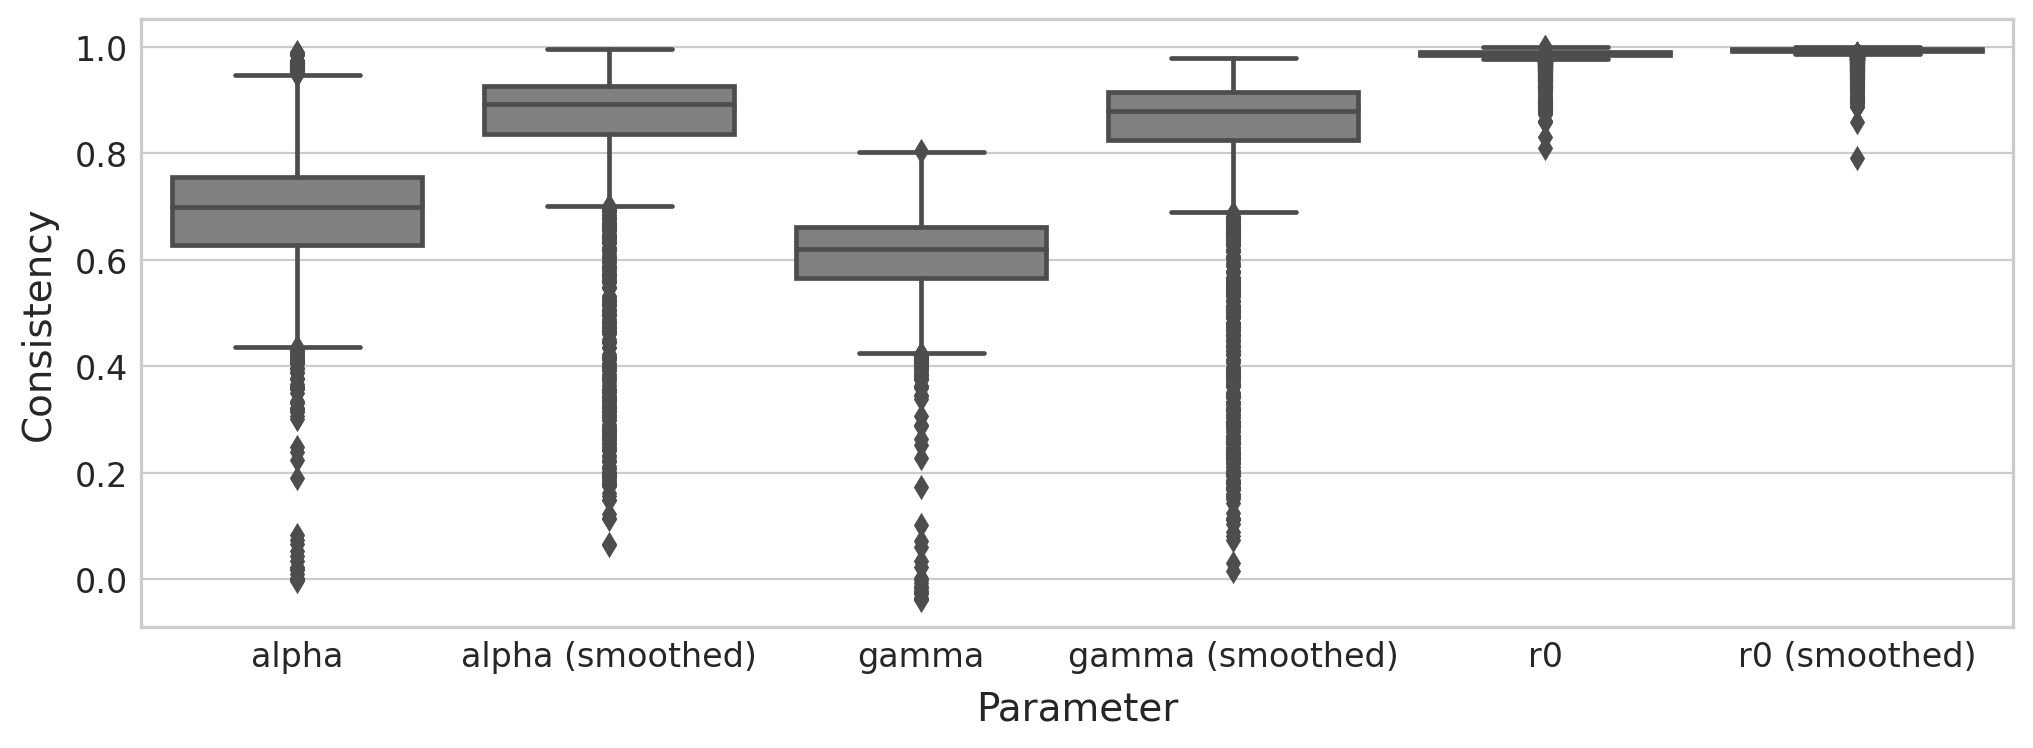

In [9]:
df = pd.DataFrame(
    {
        "Consistency": np.hstack(consistency.values()),
        "Parameter": list(itertools.chain(*[[parameter] * adata.n_obs for parameter in consistency.keys()])),
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(12, 4))
    sns.boxplot(data=df, x="Parameter", y="Consistency", color="grey", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "kinetic_rates_consistency.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )